In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, classification_report
from lightgbm import LGBMClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import statsmodels.api as sm
from library.sb_utils import save_file

In [100]:
stock_data = pd.read_csv('../data/stock_data_preprocessed.csv')

In [101]:
stock_data.head().T

,0,1,2,3,4
Date,1984-09-11,1985-02-13,1985-05-02,1985-05-22,1985-05-29
Open,0.42516,0.47512,0.32911,0.33041,0.27279
High,0.43668,0.47512,0.32911,0.33297,0.27535
Low,0.42516,0.45335,0.30733,0.32911,0.27279
Close,0.42902,0.45335,0.30733,0.32911,0.27279
Volume,42498199,146978950,91968038,33621242,68760507
OpenInt,0,0,0,0,0
Stock,AAPL,AAPL,AAPL,AAPL,AAPL
Change,0.00386,-0.02177,-0.02178,-0.0013,0.0
Loss,-0.00386,0.02177,0.02178,0.0013,0.0


In [102]:
X = stock_data.drop(columns=['Date', 'Stock', 'Target', 'Average', 'OpenInt', 'Change','Daily Return','Cumulative Return', 'Loss']) 
  # Assuming this is the features 
y = stock_data['Target']  # Assuming this is the target variable


In [103]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,  
    test_size=0.3,  # 30% for testing
    random_state=42,
    shuffle=False, # Do not shuffle the data
)

## Random Forest Classifier

In [104]:
RF = RandomForestClassifier(criterion='gini', n_estimators=500, min_samples_split=100, random_state=1)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

In [105]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\n                        Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5976781425140112
Precision: 0.7628865979381443
Recall: 0.33867276887871856
F1 Score: 0.46909667194928684

                        Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.88      0.68      1187
           1       0.76      0.34      0.47      1311

    accuracy                           0.60      2498
   macro avg       0.66      0.61      0.57      2498
weighted avg       0.66      0.60      0.57      2498



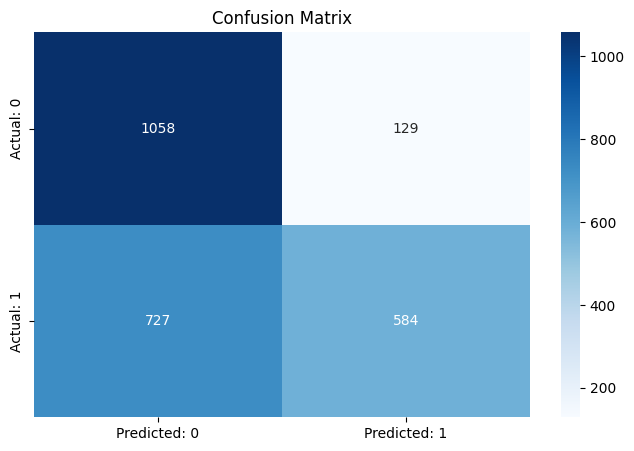

In [147]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 5))  
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: 0', 'Predicted: 1'], 
            yticklabels=['Actual: 0', 'Actual: 1'], 
            )  

plt.title("Confusion Matrix")
plt.show()

In [107]:


# Define the parameter grid you want to search over
param_grid = {
    'n_estimators': [50, 100, 200],            
    'max_depth': [2, 8, 10, None],            
    'min_samples_split': [2, 4, 10],
    'criterion': ['gini', 'entropy']         
}

# Initialize the RandomForestClassifier 
rf = RandomForestClassifier(random_state=42)

# Setup GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,           

)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best hyperparameters:", grid_search.best_params_)

# Use the best model to predict test data
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Evaluating the performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\n                        Classification Report:")
print(classification_report(y_test, y_pred))


Best hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 4, 'n_estimators': 200}
Accuracy: 0.6573258606885508
Precision: 0.8190743338008415
Recall: 0.4454614797864226
F1 Score: 0.5770750988142292

                        Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.89      0.71      1187
           1       0.82      0.45      0.58      1311

    accuracy                           0.66      2498
   macro avg       0.71      0.67      0.64      2498
weighted avg       0.71      0.66      0.64      2498



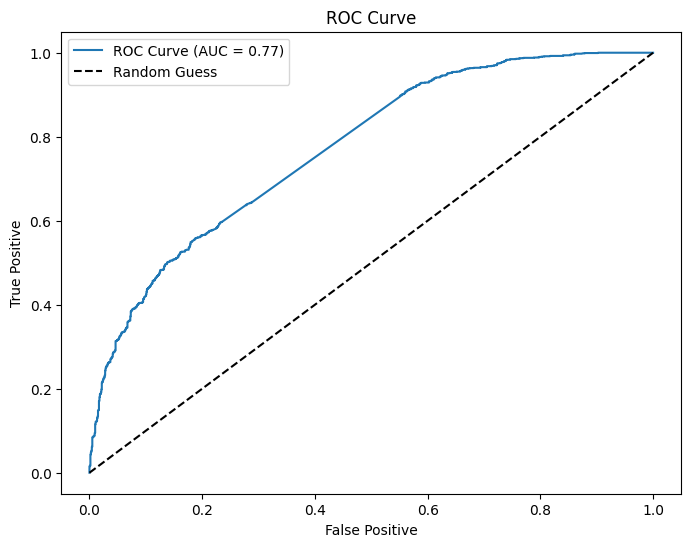

In [108]:
y_prob = best_rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend()
plt.show()

## XGBoostClassifier

In [109]:

xgb = XGBClassifier(eval_metric='logloss', random_state=42 )
# Fit the model
xgb.fit(X_train, y_train)

# Predict
y_pred_xbg = xgb.predict(X_test)


# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_xbg))
print("Precision:", precision_score(y_test, y_pred_xbg))
print("Recall:", recall_score(y_test, y_pred_xbg))
print("F1 Score:", f1_score(y_test, y_pred_xbg))
print("\n                        Classification Report:\n", classification_report(y_test, y_pred_xbg))

Accuracy: 0.6869495596477182
Precision: 0.7690742624618515
Recall: 0.5766590389016019
F1 Score: 0.6591107236268526

                        Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.81      0.71      1187
           1       0.77      0.58      0.66      1311

    accuracy                           0.69      2498
   macro avg       0.70      0.69      0.68      2498
weighted avg       0.70      0.69      0.68      2498



In [110]:

grid_search = GridSearchCV(
    xgb,
    param_grid,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    refit='f1',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)


best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("\n                        Classification Report:")
print(classification_report(y_test, y_pred_xgb))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:20:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "criterion", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:20:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "criterion", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:20:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "criterion", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/traini

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:20:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "criterion", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:20:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "criterion", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:20:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "criterion", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/traini

Best parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.6933546837469976
Precision: 0.8255675029868578
Recall: 0.5270785659801678
F1 Score: 0.6433891992551211

                        Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.88      0.73      1187
           1       0.83      0.53      0.64      1311

    accuracy                           0.69      2498
   macro avg       0.73      0.70      0.69      2498
weighted avg       0.73      0.69      0.69      2498



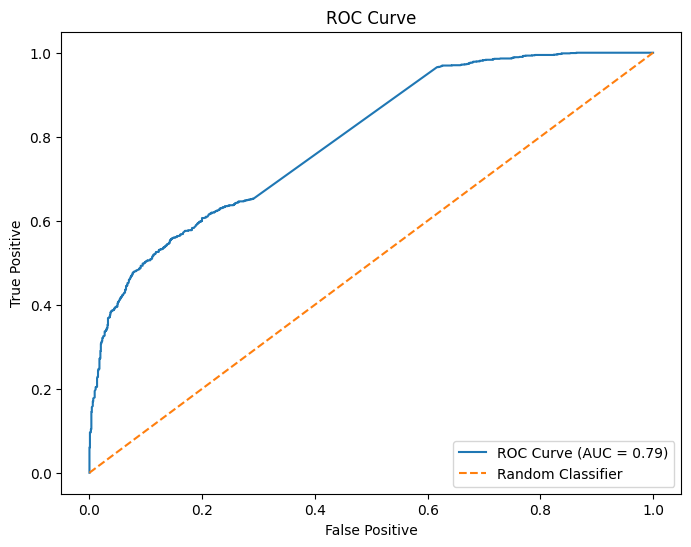

In [128]:
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)

roc_auc = roc_auc_score(y_test, y_proba_xgb)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

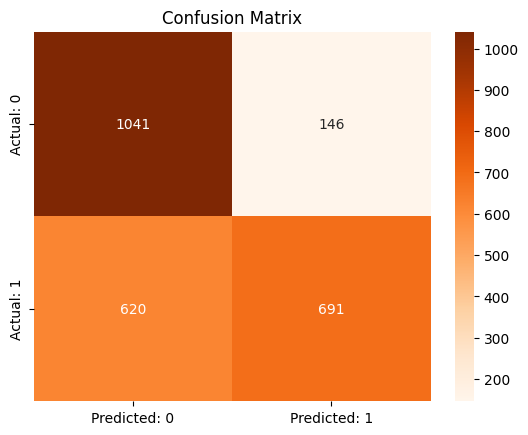

In [124]:
cm_lgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Oranges', xticklabels=['Predicted: 0', 'Predicted: 1'],
            yticklabels=['Actual: 0', 'Actual: 1'])
plt.title('Confusion Matrix')
plt.show()

## LGBM Classifier

In [112]:
lgb = LGBMClassifier(random_state=42)
lgb.fit(X_train, y_train)
y_pred_lgb = lgb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("Precision:", precision_score(y_test, y_pred_lgb))
print("Recall:", recall_score(y_test, y_pred_lgb))
print("F1 Score:", f1_score(y_test, y_pred_lgb))
print("\n                        Classification Report:\n", classification_report(y_test, y_pred_lgb))

Accuracy: 0.6733386709367494
Precision: 0.7828571428571428
Recall: 0.5225019069412662
F1 Score: 0.6267154620311071

                        Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.84      0.71      1187
           1       0.78      0.52      0.63      1311

    accuracy                           0.67      2498
   macro avg       0.70      0.68      0.67      2498
weighted avg       0.70      0.67      0.67      2498



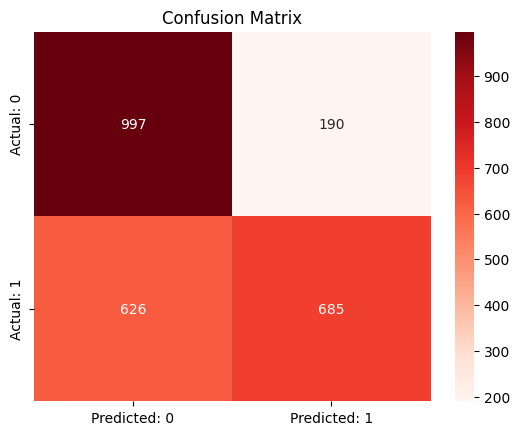

In [113]:
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Reds', xticklabels=['Predicted: 0', 'Predicted: 1'],
            yticklabels=['Actual: 0', 'Actual: 1'])
plt.title('Confusion Matrix')
plt.show()

In [114]:

lgb_grid_search = GridSearchCV(
    LGBMClassifier(random_state=42, verbose=-1),  
    param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

lgb_grid_search.fit(X_train, y_train)
print("Best parameters for LGBM:", lgb_grid_search.best_params_)

best_lgb = lgb_grid_search.best_estimator_
y_pred_lgb = best_lgb.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("Precision:", precision_score(y_test, y_pred_lgb))    
print("Recall:", recall_score(y_test, y_pred_lgb))  
print("F1 Score:", f1_score(y_test, y_pred_lgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgb))


Best parameters for LGBM: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.6741393114491593
Precision: 0.8094645080946451
Recall: 0.4958047292143402
F1 Score: 0.6149479659413434

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.87      0.72      1187
           1       0.81      0.50      0.61      1311

    accuracy                           0.67      2498
   macro avg       0.71      0.68      0.67      2498
weighted avg       0.71      0.67      0.66      2498



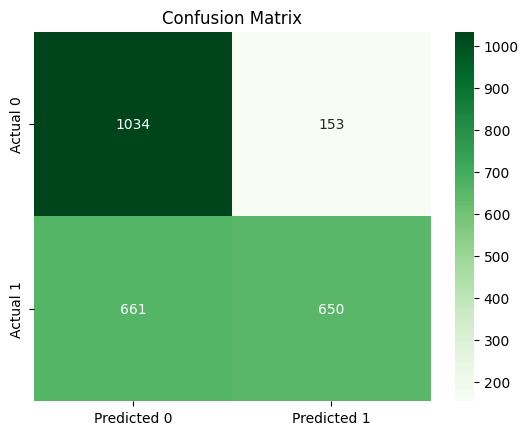

In [115]:
cm = confusion_matrix(y_test, y_pred_lgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()

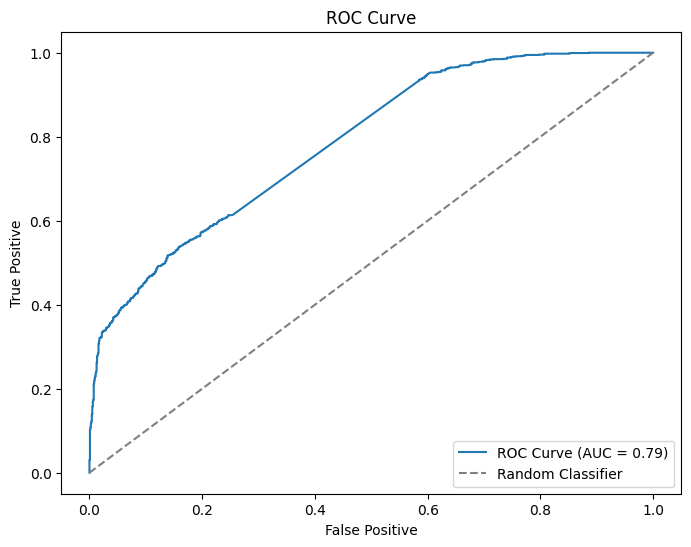

In [133]:

y_proba_lgb = best_lgb.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lgb)
roc_auc = roc_auc_score(y_test, y_proba_lgb)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## Gradient Boosting Classifier

Accuracy: 0.5960768614891914
Precision: 0.5741650294695482
Recall: 0.8916857360793288
F1 Score: 0.6985360023902002

                        Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.27      0.39      1187
           1       0.57      0.89      0.70      1311

    accuracy                           0.60      2498
   macro avg       0.63      0.58      0.54      2498
weighted avg       0.63      0.60      0.55      2498



Text(0.5, 1.0, 'Confusion Matrix')

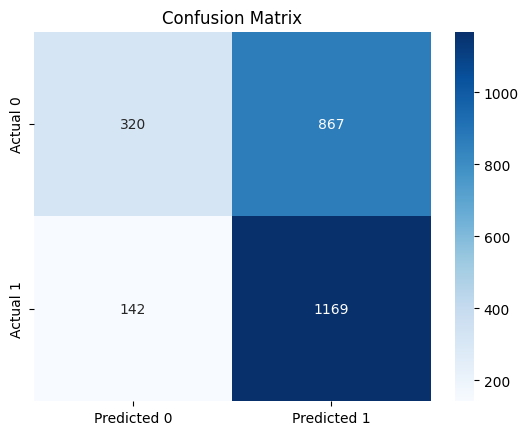

In [143]:
GB = GradientBoostingClassifier(random_state=42)
GB.fit(X_train, y_train)
y_pred_gb = GB.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Precision:", precision_score(y_test, y_pred_gb))
print("Recall:", recall_score(y_test, y_pred_gb))
print("F1 Score:", f1_score(y_test, y_pred_gb))
print("\n                        Classification Report:\n", classification_report(y_test, y_pred_gb))
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.7005604483586869
Precision: 0.6647162083089526
Recall: 0.8665141113653699
F1 Score: 0.752317880794702

                        Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.52      0.62      1187
           1       0.66      0.87      0.75      1311

    accuracy                           0.70      2498
   macro avg       0.72      0.69      0.69      2498
weighted avg       0.72      0.70      0.69      2498



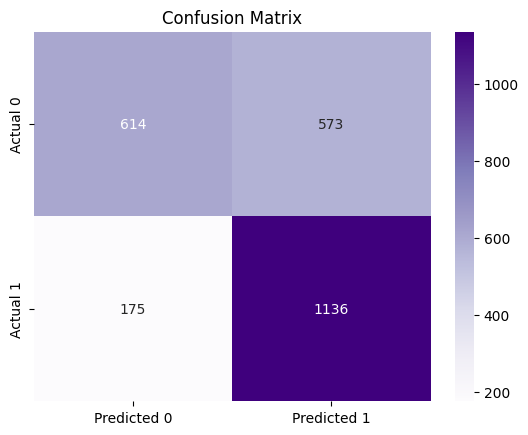

In [117]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', None]
}


GB_grid_search = GridSearchCV(GB, 
                              param_grid,
                              scoring='f1',
                              cv=5,
                              n_jobs=-1)
GB_grid_search.fit(X_train, y_train)
print("Best parameters for Gradient Boosting:", GB_grid_search.best_params_)
best_gb = GB_grid_search.best_estimator_
y_pred_gb = best_gb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Precision:", precision_score(y_test, y_pred_gb))
print("Recall:", recall_score(y_test, y_pred_gb))
print("F1 Score:", f1_score(y_test, y_pred_gb))
print("\n                        Classification Report:\n", classification_report(y_test, y_pred_gb))
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.show()



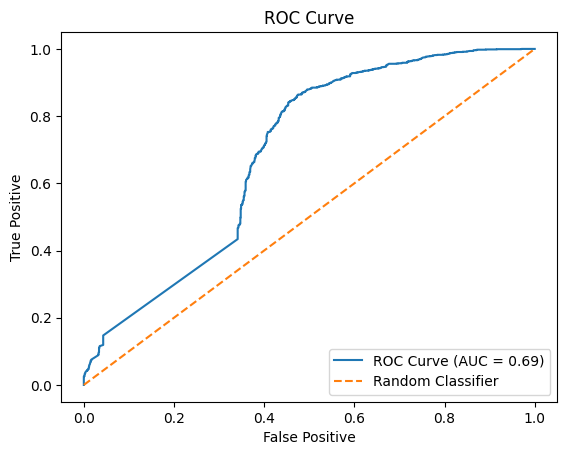

In [135]:
y_proba_gb = best_gb.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_proba_gb)    
roc_auc = roc_auc_score(y_test, y_proba_gb)
# Plot ROC curve
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier') 
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend(loc='lower right')   
plt.show()


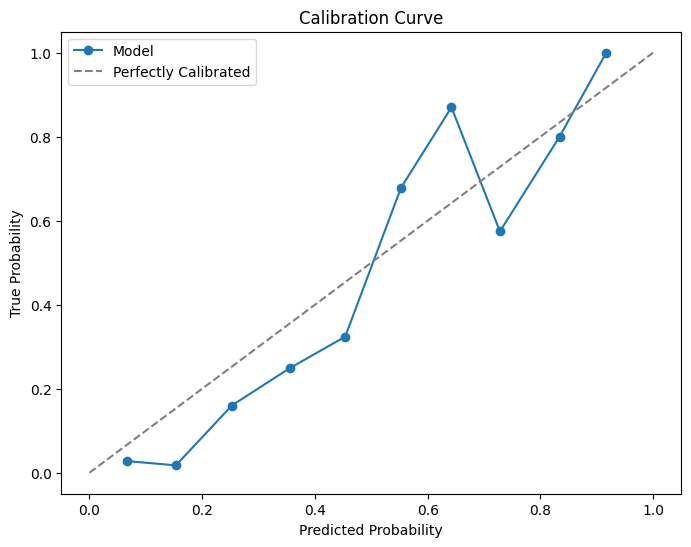

In [138]:
prob_true, prob_pred = calibration_curve(y_test, y_proba_gb, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

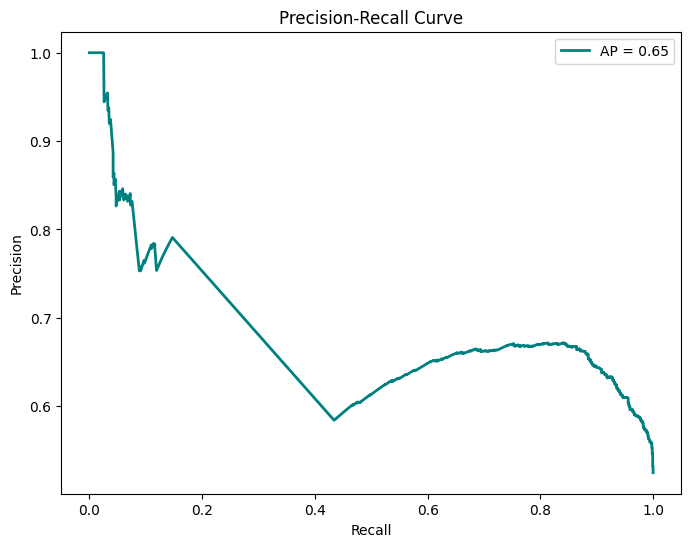

In [146]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_gb)
avg_prec = average_precision_score(y_test, y_proba_gb)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='teal', lw=2, label=f'AP = {avg_prec:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()